In [2]:
# Path bootstrap: make project root + src importable
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: /home/alonbenach/project/invoice-analysis


In [ ]:
# 1 Imports, constants, dirs
from pathlib import Path
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import joypy

from src.io_utils import list_csvs, read_csv, ensure_dir
from src.clean_utils import normalize_columns, cast_basic_types, parse_timestamp, assign_slots, is_non_product, clean_non_products
from src.fc_map_utils import normalize_text, fc_family_from_line
from src.viz_utils import (save_bar, save_hist, save_box, 
                           plot_basket_fc_by_slot, 
                           plot_basket_fc_by_slot_thematic, 
                           shorten_labels, 
                           plot_top_copurchase_horizontal, 
                           plot_fc_heatmap_weekday_slot, plot_top_fc_anchors,
                           plot_fc_copurchase_tilemap)

%load_ext autoreload
%autoreload 2

DATA_DIR   = PROJECT_ROOT / "data" / "invoices"
REF_DIR    = PROJECT_ROOT / "data" / "refs"
OUT_DIR    = PROJECT_ROOT / "outputs_large" / "core"
PLOTS      = OUT_DIR / "plots"
PROCESSED = PROJECT_ROOT / "data" / "processed"
CFG_SLOTS  = PROJECT_ROOT / "config" / "slots.yaml"

ensure_dir(OUT_DIR); ensure_dir(PLOTS)
pd.options.display.max_columns = 200


In [4]:
# 2 load the cleaned data
# Prefer Parquet
parq = PROCESSED / "invoices_2025-09_clean.parquet"
csvg = PROCESSED / "invoices_2025-09_clean.csv.gz"
latest_parq = PROCESSED / "latest.parquet"
latest_csvg = PROCESSED / "latest.csv.gz"

if parq.exists():
    df = pd.read_parquet(parq)
elif latest_parq.exists():
    df = pd.read_parquet(latest_parq)
elif csvg.exists():
    df = pd.read_csv(csvg, low_memory=False)
else:
    df = pd.read_csv(latest_csvg, low_memory=False)

print(f"Loaded rows: {len(df):,}")
df


Loaded rows: 260,000


,basket_id,receipt_id,ts,purchase_date,purchase_time,slot_id,slot_label,product_line,product_name,qty,unit_price_gross,line_value_gross,is_food_corner_auto,match_category,best_match_item,score
0,31006967,31006967,2025-01-09 07:07:00+01:00,2025-09-01,07:07,1.0,Going to work,KAJZERKA xxl 95g-C,None,2.0,0.79,1.58,False,Kajzerki,Kajzerka kebab,72
1,31006967,31006967,2025-01-09 07:07:00+01:00,2025-09-01,07:07,1.0,Going to work,SER TOPIONY TOST PLASTRY 130g-C,Sertop Tychy Ser topiony w plastrach tost 130 ...,1.0,6.40,6.40,False,Tosty,Tost z szynką i serem,42
2,31006967,31006967,2025-01-09 07:07:00+01:00,2025-09-01,07:07,1.0,Going to work,CHLEB TOST PELNOZ-C,None,1.0,4.99,4.99,True,Tosty,Tost z szynką i serem,45
3,31007786,31007786,2025-01-09 08:37:00+01:00,2025-09-01,08:37,1.0,Going to work,BAGIETKA SZ JAJKO-C,None,1.0,11.99,11.99,True,Bagietki,Bagietka Cezar,72
4,31007821,31007821,2025-01-09 08:57:00+01:00,2025-09-01,08:57,1.0,Going to work,MLEKO 500g GOSTYN-C,SM Gostyn Mleko gostynskie zageszczone lekkie ...,1.0,6.99,6.99,False,Hot Dog,Hot dog z kabanosem,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259995,31989763,31989763,NaT,2025-09-16,16:10,NaN,None,PAP LxM FC BRIG SL-A,PAPIEROSY L&M FIRST CUT BRIGHT,1.0,20.50,20.50,False,Kanapki,Kanapka niski IG / pasta jajeczna,39
259996,31989763,31989763,NaT,2025-09-16,16:10,NaN,None,KARTA HIPZZ MENTHOL 1SZT-A,Karta aromatyzujaca HIPZZ menthol,1.0,1.80,1.80,False,Pizza na wynos,Pizza Quattro formaggi,41
259997,31989763,31989763,NaT,2025-09-16,16:10,NaN,None,PAP LxM FC BRIG KS-A,PAPIEROSY L&M FIRST CUT BRIGHT,1.0,20.50,20.50,False,Bajgle,Bajgiel z salami,44
259998,31989769,31989769,NaT,2025-09-16,13:05,NaN,None,JAGODZIANKA STOKSON 100g-C,CIASTKA SWEET DELISE JAGODZIANKA 500G,2.0,3.50,7.00,False,Kanapki,Kanapka niski IG / pasta jajeczna,45


In [5]:
#3 light sanity & required columns
required = {"basket_id","receipt_id","ts","product_line","qty","unit_price_gross","line_value_gross","is_food_corner_auto"}
missing = required - set(df.columns)
print("Missing required columns:", missing)

# Types
df["is_food_corner_auto"] = df["is_food_corner_auto"].astype("boolean")
df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
df["date"] = df["ts"].dt.date


Missing required columns: set()


In [6]:
# 4 top KPIs (baskets & value)
# Basket-level presence of FC
grp = df.groupby("basket_id")["is_food_corner_auto"]
baskets_total = grp.size().shape[0] if hasattr(grp.size(), 'shape') else df["basket_id"].nunique()
baskets_with_fc = grp.any().sum()
basket_fc_share = baskets_with_fc / (df["basket_id"].nunique())

# Basket values
val_by_basket = df.groupby("basket_id")["line_value_gross"].sum()
avg_receipt = val_by_basket.mean()

# FC vs non-FC value share (line level)
fc_value_share = df.loc[df["is_food_corner_auto"]==True, "line_value_gross"].sum() / df["line_value_gross"].sum()

summary = pd.DataFrame([{
    "baskets_total": int(df["basket_id"].nunique()),
    "baskets_with_fc": int(baskets_with_fc),
    "basket_fc_share": float(basket_fc_share),
    "avg_receipt_value": float(avg_receipt),
    "fc_line_value_share": float(fc_value_share),
}])
summary.to_csv(OUT_DIR/"kpi_overview.csv", index=False)
summary


,baskets_total,baskets_with_fc,basket_fc_share,avg_receipt_value,fc_line_value_share
0,123246,12991,0.105407,23.836862,0.049953


In [7]:
# 5 FC by weekday × slot (heatmap CSV + quick plot)
# Count of FC lines per weekday x slot
df["weekday"] = df["ts"].dt.day_name()
fc_heatmap = (df[df["is_food_corner_auto"]==True]
           .groupby(["weekday","slot_label"])
           .size().unstack(fill_value=0))
fc_heatmap.to_csv(OUT_DIR/"fc_count_heatmap_weekday_slot.csv")

fc_heat = fc_heatmap.copy()

# Remove outlier slot from visualization
if "Probably outliers" in fc_heat.columns:
    fc_heat = fc_heat.drop(columns=["Probably outliers"])

# Order weekdays Mon→Sun if they’re all present
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
existing = [d for d in weekday_order if d in fc_heat.index]
if existing:
    fc_heat = fc_heat.reindex(existing)
    
plot_fc_heatmap_weekday_slot(
    fc_heat,
    PLOTS/"fc_heatmap_weekday_slot.png",
    theme="dark",
)



In [8]:
# Split FC vs non-FC
fc     = df[df["is_food_corner_auto"] == True].copy()
nonfc  = df[df["is_food_corner_auto"] != True].copy()

# Drop packaging / non-product lines from the companion side
NON_PRODUCTS = ["torba", "butelka", "opak", "kompania", "reklam", "kubek"]

def is_non_product(name: str) -> bool:
    if not isinstance(name, str):
        return False
    lower = name.lower()
    return any(pat in lower for pat in NON_PRODUCTS)

nonfc = nonfc[~nonfc["product_line"].astype(str).apply(is_non_product)]

# For safety, also drop torba-like FC lines if any slipped in
fc = fc[~fc["product_line"].astype(str).apply(is_non_product)]

# Unique (basket, product_line) pairs to avoid double-counting within the same receipt
fc_uni    = fc[["basket_id","product_line"]].drop_duplicates()
nonfc_uni = nonfc[["basket_id","product_line"]].drop_duplicates()

In [9]:
# Count baskets per FC product_line
fc_basket_counts = (
    fc_uni.groupby("product_line")["basket_id"]
          .nunique()
          .sort_values(ascending=False)
)

top_k = 8
top_fc = fc_basket_counts.head(top_k)
top_fc


product_line
HOT DOG PAR Z SZYN-B             1346
HOT DOG Z PAR. Z SZYN. XXL-B     1217
HOT DOG MAXX GRILL-B              934
HOT-DOG Z KABANOSEM GX-B          807
FRYTKI 150g-B                     767
HOT-DOG Z KIELB. BEKON - GX-B     600
HOT DOG MAXX-B                    535
BAGIETKA HOT STR-C                453
Name: basket_id, dtype: int64

In [10]:
# All FC lines
fc_lines = df[df["is_food_corner_auto"]].copy()

# Map each product_line to a FC family
fc_lines["fc_family"] = fc_lines["product_line"].apply(fc_family_from_line)

# Count baskets per family (not per SKU)
baskets_per_family = (
    fc_lines.groupby("fc_family")["basket_id"]
            .nunique()
            .sort_values(ascending=False)
)

top_n = 8
top_fc_families = baskets_per_family.head(top_n)
top_fc_families


plot_top_fc_anchors(top_fc_families, PLOTS/"fc_anchors_top8.png", theme="dark")


In [ ]:
# copurchase heatmap: FC families vs companion products

fc_uni_fam = fc_uni.copy()
fc_uni_fam["fc_family"] = fc_uni_fam["product_line"].map(fc_family_from_line)

# keep only lines we can classify
fc_uni_fam = fc_uni_fam[fc_uni_fam["fc_family"].notna()].copy()

# --- 2. Pick top FC families (instead of top FC lines) ---

family_counts = (
    fc_uni_fam.groupby("fc_family")["basket_id"]
              .nunique()
              .sort_values(ascending=False)
)

top_k = 8
top_families = family_counts.head(top_k).index

# Limit FC side to baskets that contain one of the top FC families
fc_top = fc_uni_fam[fc_uni_fam["fc_family"].isin(top_families)].copy()

# --- 3. All pairs (FC family, non-FC product) within the same basket ---

pairs = fc_top.merge(
    nonfc_uni,
    on="basket_id",
    suffixes=("_fc", "_other"),
)

# Count baskets per pair: (FC family, companion product_line)
pair_counts = (
    pairs.groupby(["fc_family", "product_line_other"])
         .size()
         .rename("count")
)

# --- 4. Choose top companions globally (same logic as before) ---

companion_totals = (
    pair_counts
    .groupby(level="product_line_other")
    .sum()
    .sort_values(ascending=False)
)

top_m = 10
top_companions = companion_totals.head(top_m).index

# --- 5. Build matrix: rows = FC families, cols = companion products ---

matrix = (
    pair_counts.reset_index()
               .query("product_line_other in @top_companions")
               .pivot_table(
                    index="fc_family",
                    columns="product_line_other",
                    values="count",
                    aggfunc="sum",
                    fill_value=0,
               )
)

# Ensure row order matches the family ranking we just computed
matrix = matrix.reindex(top_families, axis=0)

plot_fc_copurchase_tilemap(matrix, PLOTS/"fc_copurchase_tilemap.png", theme="dark")

/tmp/ipykernel_2298/2043215901.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Greens" if theme == "zabka" else


In [ ]:
# 6 co-purchase (top companions with FC)
NON_PRODUCTS = ["torba", "opak", "kompania", "torb", "opakowani", "reklam"]

def clean_non_products(series , non_products) -> pd.Series:
    clean_index = [
        idx for idx in series.index
        if not any(word in idx.lower() for word in NON_PRODUCTS)
    ]
    return series.loc[clean_index]

# Baskets that contain FC
fc_baskets = set(df.groupby("basket_id")["is_food_corner_auto"].any()
                   .pipe(lambda s: s[s].index))

# Non-FC lines on those baskets = companions
cop = df[(df["basket_id"].isin(fc_baskets)) & (df["is_food_corner_auto"] != True)].copy()

# Top companions by product_line / product_name
cop_line = (cop.groupby("product_line")["qty"].sum()
              .sort_values(ascending=False).head(15))
cop_line = clean_non_products(cop_line, non_products=NON_PRODUCTS)

cop_name = (cop.groupby("product_name")["qty"].sum()
              .sort_values(ascending=False).head(15))

cop_line.to_csv(OUT_DIR/"copurchase_top_product_lines.csv", header=["qty"])
cop_name.to_csv(OUT_DIR/"copurchase_top_product_names.csv", header=["qty"])

if not cop_line.empty:
    plot_top_copurchase_horizontal(
        cop_line,
        "Top products co-purchased with Food Corner (by product line)",
        PLOTS/"copurchase_by_product_line.png",
        theme="dark",
        top_n=15,
        label_max_len=34,
    )

if not cop_name.empty:
    plot_top_copurchase_horizontal(
        cop_name,
        "Top products co-purchased with Food Corner (by product name)",
        PLOTS/"copurchase_by_product_name.png",
        theme="dark",
        top_n=15,
        label_max_len=40,
    )


print({"cop_rows": int(len(cop)), "top_lines": int(cop_line.shape[0]), "top_names": int(cop_name.shape[0])})


{'cop_rows': 20424, 'top_lines': 12, 'top_names': 15}


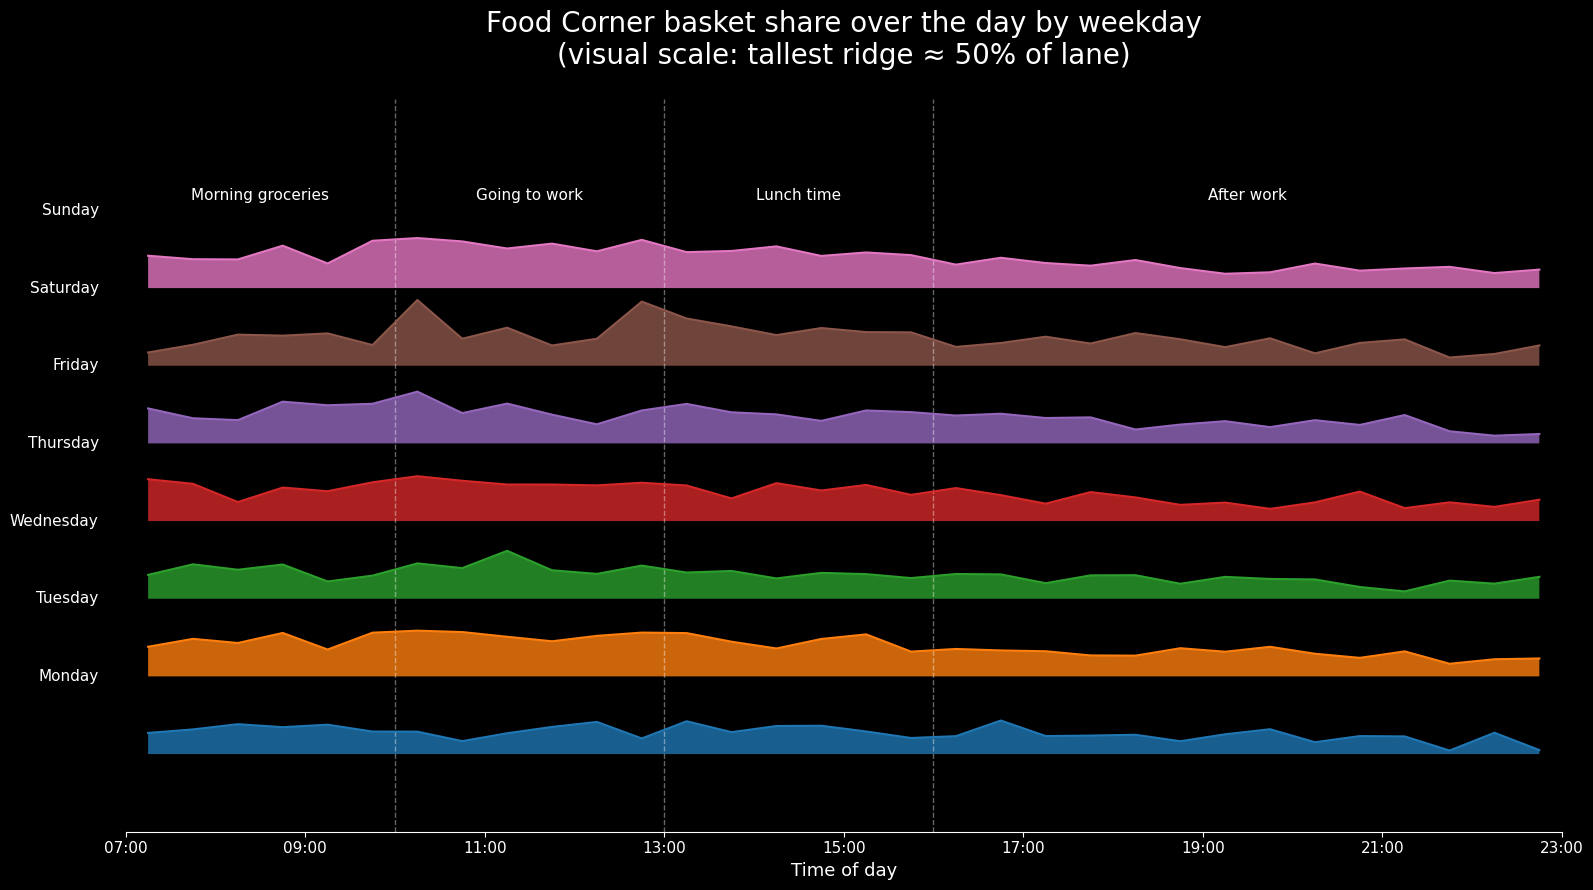

In [14]:
# 7 ridge joy plot of FC of invoices containing FC at days of week
# 1 row per basket: when it happened + whether it has FC
baskets = (
    df.groupby("receipt_id")
      .agg(
          ts=("ts", "min"),                         # basket timestamp
          has_fc=("is_food_corner_auto", "max"),   # any FC line in that basket
      )
      .reset_index()
)

baskets["weekday"] = baskets["ts"].dt.day_name()
baskets["hour"] = baskets["ts"].dt.hour + baskets["ts"].dt.minute / 60.0


# 30-minute bins across the day
bin_width = 0.5
bins = np.arange(0, 24 + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

fc_share_by_day = {}

for wd in weekday_order:
    tmp = baskets[baskets["weekday"] == wd]

    # total baskets per bin
    total_counts = pd.cut(tmp["hour"], bins=bins, labels=bin_centers).value_counts().sort_index()

    # FC baskets per bin
    fc_counts = pd.cut(tmp.loc[tmp["has_fc"], "hour"], bins=bins,
                       labels=bin_centers).value_counts().sort_index()

    share = (fc_counts / total_counts).fillna(0.0)
    fc_share_by_day[wd] = share


plt.style.use("default")

fig, ax = plt.subplots(figsize=(16, 9), facecolor="black")
ax.set_facecolor("black")

# --- 1. scale so tallest ridge reaches 50% of its lane ---
max_share   = max(s.max() for s in fc_share_by_day.values())   # ~0.16–0.18
target_peak = 2   # visual height of tallest ridge within a lane (0–1)
scale       = target_peak / max_share

offset = target_peak * 0.3   # vertical gap between weekdays

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

# --- 2. slot boundaries + labels ---
slot_edges  = [7, 10, 13, 16, 23]
slot_labels = ["Morning groceries", "Going to work", "Lunch time", "After work"]

for h in slot_edges[1:-1]:
    ax.axvline(h, color="white", linestyle="--", linewidth=1, alpha=0.4)

x_min, x_max = 7, 23

for i, wd in enumerate(weekday_order):
    share = fc_share_by_day[wd]         # already 0–1 fractions
    x_all = share.index.astype(float)
    y_all = share.values * scale        # tallest ≈ target_peak

    mask = (x_all >= x_min) & (x_all <= x_max)
    x = x_all[mask]
    y = y_all[mask]

    baseline = i * offset

    ax.fill_between(x, baseline, baseline + y, alpha=0.8)
    ax.plot(x, baseline + y, linewidth=1.5)

    ax.text(
        x_min - 0.3,
        baseline + target_peak * 0.3,
        wd,
        ha="right",
        va="center",
        color="white",
        fontsize=11,
    )

# --- 3. slot labels on top ---
y_top    = offset * (len(weekday_order) + 0.1)
slot_mid = [(slot_edges[i] + slot_edges[i+1]) / 2 for i in range(len(slot_labels))]

for mid, label in zip(slot_mid, slot_labels):
    ax.text(
        mid,
        y_top,
        label,
        ha="center",
        va="bottom",
        color="white",
        fontsize=11,
    )

# --- 4. axes cosmetics ---
ax.set_xlim(x_min, x_max)
ax.set_xticks([7, 9, 11, 13, 15, 17, 19, 21, 23])
ax.set_xticklabels([f"{int(t):02d}:00" for t in ax.get_xticks()],
                   color="white", fontsize=11)

ax.set_yticks([])
ax.set_ylim(-target_peak * 0.3, y_top + target_peak * 0.4)

for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)
ax.spines["bottom"].set_color("white")
ax.tick_params(axis="x", colors="white")

ax.set_xlabel("Time of day", color="white", fontsize=13)
ax.set_title(
    "Food Corner basket share over the day by weekday\n"
    "(visual scale: tallest ridge ≈ 50% of lane)",
    color="white",
    fontsize=20,
    pad=25,
)

fig.tight_layout()
fig.savefig(PLOTS / "fc_ridge_by_weekday.png",
            dpi=150, facecolor=fig.get_facecolor())